# Exploring Bias in Tweets by Members of Congress

---

### Contributors: Alex Shropshire, Mando Iwanaga

### Goal: Use transfer learning (Pre-trained BERT model) to classify tweet text from Politicians as having a democratic bias, a republican bias, or neutrality.

### Process

**1.Business Understanding  
2.Understand the data  
3.Prepare the data for analysis and modeling  
4.Model  
5.Evaluate Results  
6.Deploy**

---

**Import Necessary libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from keras import Model
from keras.layers import Lambda, Dense
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

from batch_generator.batch_generator import BatchGenerator
from load_pretrained_bert import load_google_bert
import string

---

## Data Preparation

**We'll begin by uploading our dataset retrieved from [figure-eight](https://www.figure-eight.com/data-for-everyone/), an open source data platform.**

In [3]:
#Upload dataset with only the necessary columns
raw_df = pd.read_csv('Political-media-DFE.csv',encoding='latin')
df = raw_df[['bias','message','embed','label','source','text']]
df.head()

,bias,message,embed,label,source,text
0,partisan,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",From: Trey Radel (Representative from Florida),twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,partisan,attack,"<blockquote class=""twitter-tweet"" width=""450"">...",From: Mitch McConnell (Senator from Kentucky),twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,neutral,support,"<blockquote class=""twitter-tweet"" width=""450"">...",From: Kurt Schrader (Representative from Oregon),twitter,Please join me today in remembering our fallen...
3,neutral,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",From: Michael Crapo (Senator from Idaho),twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,partisan,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",From: Mark Udall (Senator from Colorado),twitter,.@amazon delivery #drones show need to update ...


In [4]:
df['bias'].value_counts()

neutral     3689
partisan    1311
Name: bias, dtype: int64

**The dataset does not specify political affiliation, will need to add politician's affiliations**

In [5]:
#Make a function to clean text of puntuations
def remove_punctuations(text):
    '''Removes punctuation from strings'''
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [6]:
#Apply our remove_punctuations function
df['text'] = df.loc[:,'text'].apply(remove_punctuations)
df['label'] = df['label'].str.replace('From: ','')
df['text'] = df['text'].str.lower()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [7]:
#Create a new column with the tweet purpose and bias
df['purpose_and_bias'] = df['message'] + '_' + df['bias']


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
df.head()

,bias,message,embed,label,source,text,purpose_and_bias
0,partisan,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",Trey Radel (Representative from Florida),twitter,rt nowthisnews rep trey radel r fl slams obama...,policy_partisan
1,partisan,attack,"<blockquote class=""twitter-tweet"" width=""450"">...",Mitch McConnell (Senator from Kentucky),twitter,video obamacare full of higher costs and bro...,attack_partisan
2,neutral,support,"<blockquote class=""twitter-tweet"" width=""450"">...",Kurt Schrader (Representative from Oregon),twitter,please join me today in remembering our fallen...,support_neutral
3,neutral,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",Michael Crapo (Senator from Idaho),twitter,rt senatorleahy 1st step toward senate debate ...,policy_neutral
4,partisan,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",Mark Udall (Senator from Colorado),twitter,amazon delivery drones show need to update law...,policy_partisan


In [10]:
#Load dataset of politicians and their affiliations
congressmen_df = pd.read_csv('congressmen_2015.csv')
congressmen_df.head()

,First,Last,congressman,affiliation
0,Gregorio,Sablan,Gregorio Sablan (Representative from NA),d
1,Robert,Aderholt,Robert Aderholt (Representative from Alabama),r
2,Lamar,Alexander,Lamar Alexander (Senator from Tennessee),r
3,Justin,Amash,Justin Amash (Representative from Michigan),r
4,Mark,Amodei,Mark Amodei (Representative from Nevada),r


**Join the two datasets to include politicians affiliations and our target variable**

In [11]:
#partisan tweets will be labeled as the politicians affiliation in target column
#neutral tweets will be labeled as neutral in target column
df = df.merge(congressmen_df, how='left',left_on='label',right_on='congressman')
df.loc[df.bias == 'partisan', 'target'] = df['affiliation']
df.loc[df.bias == 'neutral', 'target'] = df['bias']
df.dropna(axis=0,inplace=True)

In [ ]:
#drop rows with target label as "i" 
df = df[df['target'] != 'i']

In [12]:
df.head()

,bias,message,embed,label,source,text,purpose_and_bias,First,Last,congressman,affiliation,target
0,partisan,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",Trey Radel (Representative from Florida),twitter,rt nowthisnews rep trey radel r fl slams obama...,policy_partisan,Trey,Radel,Trey Radel (Representative from Florida),r,r
1,partisan,attack,"<blockquote class=""twitter-tweet"" width=""450"">...",Mitch McConnell (Senator from Kentucky),twitter,video obamacare full of higher costs and bro...,attack_partisan,Mitch,McConnell,Mitch McConnell (Senator from Kentucky),r,r
2,neutral,support,"<blockquote class=""twitter-tweet"" width=""450"">...",Kurt Schrader (Representative from Oregon),twitter,please join me today in remembering our fallen...,support_neutral,Kurt,Schrader,Kurt Schrader (Representative from Oregon),d,neutral
3,neutral,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",Michael Crapo (Senator from Idaho),twitter,rt senatorleahy 1st step toward senate debate ...,policy_neutral,Michael,Crapo,Michael Crapo (Senator from Idaho),r,neutral
4,partisan,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",Mark Udall (Senator from Colorado),twitter,amazon delivery drones show need to update law...,policy_partisan,Mark,Udall,Mark Udall (Senator from Colorado),d,d


In [13]:
#We have 3 target classifications
df['target'].value_counts()

neutral    3631
r           791
d           490
Name: target, dtype: int64

---

## Text Cleaning

**We'll create functions to clean our text**

In [9]:
def replace_contraction(text):
    """Replace contractions from text"""
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

In [11]:
def replace_links(text, filler=' '):
    """Replace url links included in text"""
    text = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                      filler, text).strip()
    return text

In [12]:
def remove_numbers(text):
    """Remove numbers from text"""
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [13]:
#Create a function to incorporate three functions above in one
def cleanText(text):
    """Incorporate three created functions above into one"""
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = replace_contraction(text)
    text = replace_links(text, "link")
    text = remove_numbers(text)
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = text.lower()
    return text

**Label our target variables in single column**

In [16]:
df.loc[df['target'] == 'neutral', 'target'] = 0
df.loc[df['target'] == 'r', 'target'] = 1
df.loc[df['target'] == 'd', 'target'] = 2
df.head()

,bias,message,embed,label,source,text,purpose_and_bias,First,Last,congressman,affiliation,target
0,partisan,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",Trey Radel (Representative from Florida),twitter,rt nowthisnews rep trey radel r fl slams obama...,policy_partisan,Trey,Radel,Trey Radel (Representative from Florida),r,1
1,partisan,attack,"<blockquote class=""twitter-tweet"" width=""450"">...",Mitch McConnell (Senator from Kentucky),twitter,video obamacare full of higher costs and bro...,attack_partisan,Mitch,McConnell,Mitch McConnell (Senator from Kentucky),r,1
2,neutral,support,"<blockquote class=""twitter-tweet"" width=""450"">...",Kurt Schrader (Representative from Oregon),twitter,please join me today in remembering our fallen...,support_neutral,Kurt,Schrader,Kurt Schrader (Representative from Oregon),d,0
3,neutral,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",Michael Crapo (Senator from Idaho),twitter,rt senatorleahy 1st step toward senate debate ...,policy_neutral,Michael,Crapo,Michael Crapo (Senator from Idaho),r,0
4,partisan,policy,"<blockquote class=""twitter-tweet"" width=""450"">...",Mark Udall (Senator from Colorado),twitter,amazon delivery drones show need to update law...,policy_partisan,Mark,Udall,Mark Udall (Senator from Colorado),d,2


---

## Incorporating BERT 

In [15]:
#!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

In [16]:
#!unzip multi_cased_L-12_H-768_A-12.zip

In [14]:
#Upload pretrained BERT model
BERT_PRETRAINED_DIR = 'multi_cased_L-12_H-768_A-12/'
SEQ_LEN = 70
BATCH_SIZE = 12
LR = 0.001

In [18]:
# Define our X and Y variables and apply cleanText function
X = df['text'].apply(cleanText).values
Y = df['target'].values
print(X[0])  
print(Y[0])  

rt nowthisnews rep trey radel r fl slams obamacare politics httpstcozvywmgyih
1


In [19]:
#split our data into training sets and test sets using default parameters
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

In [21]:
#Define batch generators
train_gen = BatchGenerator(X_train,
                           vocab_file=os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt'),
                           seq_len=SEQ_LEN,
                           labels=Y_train,
                           do_lower_case=False,
                           batch_size=BATCH_SIZE)
valid_gen = BatchGenerator(X_test,
                           vocab_file=os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt'),
                           seq_len=SEQ_LEN,
                           labels=Y_test,
                           do_lower_case=False,
                           batch_size=BATCH_SIZE)

W0621 17:58:44.618396 139777946162944 deprecation_wrapper.py:119] From /home/jupyter/political_bias_classifier_BERT/batch_generator/tokenization.py:74: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

100%|██████████████████████████████████████████████████████████████████████████████████| 1228/1228 [00:00<00:00, 103619.32it/s]


In [22]:
#Load BERT pretrained model and print summary
g_bert = load_google_bert(base_location=BERT_PRETRAINED_DIR, use_attn_mask=False, max_len=SEQ_LEN)
g_bert.summary()

W0621 17:58:51.940794 139777946162944 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 17:58:51.983125 139777946162944 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 17:58:52.003972 139777946162944 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0621 17:58:52.047201 139777946162944 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0621 17:58:52.055370 

bert/embeddings/LayerNorm/beta  ->  layer_normalization_1/beta:0
bert/embeddings/LayerNorm/gamma  ->  layer_normalization_1/gamma:0
bert/embeddings/position_embeddings  ->  PositionEmbedding/embeddings:0
bert/embeddings/token_type_embeddings  ->  SegmentEmbedding/embeddings:0
bert/embeddings/word_embeddings  ->  TokenEmbedding/embeddings:0
bert/encoder/layer_0/attention/output/LayerNorm/beta  ->  layer_0/ln_1/beta:0
bert/encoder/layer_0/attention/output/LayerNorm/gamma  ->  layer_0/ln_1/gamma:0
bert/encoder/layer_0/attention/output/dense/bias  ->  layer_0/c_attn_proj/bias:0
bert/encoder/layer_0/attention/output/dense/kernel  ->  layer_0/c_attn_proj/kernel:0
bert/encoder/layer_0/attention/self/key/bias  ->  layer_0/c_attn/bias:0
bert/encoder/layer_0/attention/self/key/kernel  ->  layer_0/c_attn/kernel:0
bert/encoder/layer_0/attention/self/query/bias  ->  layer_0/c_attn/bias:0
bert/encoder/layer_0/attention/self/query/kernel  ->  layer_0/c_attn/kernel:0
bert/encoder/layer_0/attention/sel

bert/encoder/layer_5/output/LayerNorm/beta  ->  layer_5/ln_2/beta:0
bert/encoder/layer_5/output/LayerNorm/gamma  ->  layer_5/ln_2/gamma:0
bert/encoder/layer_5/output/dense/bias  ->  layer_5/c_ffn_proj/bias:0
bert/encoder/layer_5/output/dense/kernel  ->  layer_5/c_ffn_proj/kernel:0
bert/encoder/layer_6/attention/output/LayerNorm/beta  ->  layer_6/ln_1/beta:0
bert/encoder/layer_6/attention/output/LayerNorm/gamma  ->  layer_6/ln_1/gamma:0
bert/encoder/layer_6/attention/output/dense/bias  ->  layer_6/c_attn_proj/bias:0
bert/encoder/layer_6/attention/output/dense/kernel  ->  layer_6/c_attn_proj/kernel:0
bert/encoder/layer_6/attention/self/key/bias  ->  layer_6/c_attn/bias:0
bert/encoder/layer_6/attention/self/key/kernel  ->  layer_6/c_attn/kernel:0
bert/encoder/layer_6/attention/self/query/bias  ->  layer_6/c_attn/bias:0
bert/encoder/layer_6/attention/self/query/kernel  ->  layer_6/c_attn/kernel:0
bert/encoder/layer_6/attention/self/value/bias  ->  layer_6/c_attn/bias:0
bert/encoder/layer_6

In [45]:
# Choose Layer 0 as containing the features relevant for classification; see BERT paper for further explanation on
# this choice.
classification_features = Lambda(lambda x: x[:, 0, :])(g_bert.output)
out = Dense(3, activation='softmax')(classification_features)

In [127]:
#Define model, compile, and define parameters
model = Model(g_bert.inputs, out)
model.compile(optimizer=Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
segment_input (InputLayer)      (None, 70)           0                                            
__________________________________________________________________________________________________
position_input (InputLayer)     (None, 70)           0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        (None, 70)           0                                            
__________________________________________________________________________________________________
SegmentEmbedding (Embedding)    (None, 70, 768)      1536        segment_input[0][0]              
__________________________________________________________________________________________________
PositionEm

**We will fit our model and incorporate Early Stopping**

In [128]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-08, patience=0, verbose=1, mode='auto')
callbacks_list = [early_stop]

history_log = model.fit_generator(train_gen,
                    epochs=20,
                    verbose=1,
                    validation_data=valid_gen,
                    shuffle=True, 
                    callbacks=callbacks_list)

Epoch 1/20
307/307 [==============================] - 133s 435ms/step - loss: 0.8249 - acc: 0.7324 - val_loss: 0.7734 - val_acc: 0.7328
Epoch 2/20
307/307 [==============================] - 114s 373ms/step - loss: 0.7695 - acc: 0.7408 - val_loss: 0.8217 - val_acc: 0.7328
Epoch 00002: early stopping


In [50]:
Y_test_predictions = model.predict_generator(valid_gen, verbose=1)
Y_test = Y_test[:len(Y_test_predictions)]

102/102 [==============================] - 9s 91ms/step


In [51]:
Y_test_predictions[0:5]

array([[0.7368598 , 0.18633462, 0.07680555],
       [0.7368598 , 0.18633462, 0.07680555],
       [0.7368598 , 0.18633462, 0.07680555],
       [0.7368598 , 0.18633461, 0.07680552],
       [0.73685986, 0.18633462, 0.07680551]], dtype=float32)

In [52]:
Y_test[0:5]

array([0, 0, 1, 0, 0], dtype=object)

---

## Model Evaluation

In [93]:
from keras.metrics import sparse_categorical_accuracy, categorical_accuracy

In [97]:
categorical_accuracy(Y_test, Y_test_predictions)

TypeError: Expected binary or unicode string, got 0

In [95]:
sparse_categorical_accuracy(Y_test, Y_test_predictions)

TypeError: Expected binary or unicode string, got 0

In [96]:
# for thresh in np.arange(0.1, 0.501, 0.01):
#     thresh = np.round(thresh, 2)
#     f1 = metrics.f1_score(Y_test, (Y_test_predictions > thresh).astype(int), average='micro')
#     print ({thresh})
#     print ({f1})

accuracy = accuracy_score(Y_test, Y_test_predictions)
recall = recall_score(Y_test, Y_test_predictions, average='micro')
precision = precision_score(Y_test, Y_test_predictions, average='micro')
f1 = f1_score(Y_test, Y_test_predictions, average='micro')

#print('The calculated p-value is {}'.format( round(p_val, 90) ))
print ("Accuracy: {}".format(accuracy))
print ("Recall: {}".format(recall))
print ("Precision: {}".format(precision))
print ("F-1 Score: {}".format(f1_score))


'''
After 1 Epoch
F1 score at threshold 0.32 is 0.687372802960222
Note that the results may vary slightly from run to run due to the non-deterministic nature of tensorflow/keras.
'''

ValueError: Classification metrics can't handle a mix of unknown and continuous-multioutput targets

In [64]:
classification_report(Y_test, Y_test_predictions)

ValueError: Classification metrics can't handle a mix of unknown and continuous-multioutput targets

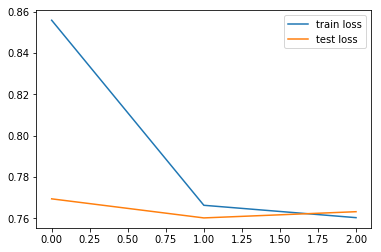

In [53]:
plt.plot(history_log.history['loss'], label = 'train loss')
plt.plot(history_log.history['val_loss'], label = 'test loss')
plt.legend();

In [88]:
import seaborn as sns
# Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

#print(f"Log loss: {log_loss(Y_test, Y_test_predictions)}")
#print(roc_auc_score(Y_test, Y_test_predictions[:,1]))
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_predictions[:,1])
# Plot
plt.plot(fpr, tpr, label='ROC curve')

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

ValueError: unknown format is not supported

In [ ]:
#calculate scores
#plot loss
#plot auc curve
#average='micro'

# update slides
#TEST sample tweets?
# update repo / README




In [65]:
history_log.history

{'loss': [0.8559505656021814, 0.7662766807339478, 0.7602843923997802],
 'sparse_categorical_accuracy': [0.7334419113950932,
  0.7410423457622528,
  0.7410423457622528],
 'val_loss': [0.7693991795474407, 0.7601562662451875, 0.763168547667709],
 'val_sparse_categorical_accuracy': [0.7328431346252853,
  0.7328431346252853,
  0.7328431346252853]}

In [124]:
mystr = "I am definitely a republican"
X_sample = np.array(list(mystr))

In [129]:
sample_tweet_gen = BatchGenerator(X_sample,
                                  vocab_file=os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt'),
                                  seq_len=SEQ_LEN,
                                  labels=Y_test,
                                  do_lower_case=False,
                                  batch_size=BATCH_SIZE)


100%|███████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 41091.85it/s]

In [130]:
sample_test_predictions = model.predict_generator(sample_tweet_gen, verbose=1)
sample_test_predictions

2/2 [==============================] - 3s 1s/step


array([[0.816972  , 0.06253493, 0.12049303],
       [0.816972  , 0.06253493, 0.12049303],
       [0.8169721 , 0.06253494, 0.12049302],
       [0.816972  , 0.06253491, 0.12049303],
       [0.816972  , 0.06253493, 0.12049303],
       [0.816972  , 0.06253491, 0.12049303],
       [0.816972  , 0.06253494, 0.12049305],
       [0.816972  , 0.06253493, 0.12049303],
       [0.816972  , 0.06253494, 0.12049303],
       [0.816972  , 0.06253493, 0.12049303],
       [0.816972  , 0.06253494, 0.12049303],
       [0.816972  , 0.06253494, 0.12049305],
       [0.816972  , 0.06253494, 0.12049305],
       [0.816972  , 0.06253493, 0.12049303],
       [0.816972  , 0.06253494, 0.12049305],
       [0.816972  , 0.06253493, 0.12049303],
       [0.8169721 , 0.06253494, 0.12049302],
       [0.816972  , 0.06253493, 0.12049303],
       [0.816972  , 0.06253494, 0.12049305],
       [0.816972  , 0.06253494, 0.12049305],
       [0.816972  , 0.06253493, 0.12049303],
       [0.816972  , 0.06253494, 0.12049303],
       [0.

In [111]:
X_test

array(['congratulations to lorraine miller a trailblazing leader who has served our country with distinction who will do an outstanding job leading the naacp as its interim president and ceo',
       'the us supreme court just handed down its decision on the voting rights act vra learn why the vra is the most effective civil rights law in history and why it\x89ûªs still needed at wwwcivilrightsorgshelby or httpbitlyldfshelby',
       'another side effect of obamacare httptcojfkaidbsp', ...,
       'what could you do with your k share of the national debt',
       'an update on fight to protect religious freedom in military on tony perkins radio show today at  et httptcoiwuosvxg',
       'message  obama oppression in cuba will not change while castro brothers r in charge more activists arrested before rally yotambienexijo'],
      dtype=object)